In [1]:
import networkx as nx
import seaborn as sns
from pathlib import Path
import torch
from DQN import DQN_agent_modular
from envs.GraphEnv.impnode import ImpnodeEnv
from DQN.train_dqn import train_dqn, fill_memory
from DQN.finetune_dqn import finetune_dqn
from DQN.test_and_compare import test_loop, hda
import matplotlib.pyplot as plt
import time
import mlflow
import  numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
import random
seed = 412
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True,warn_only=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RESULTS_BASEPATH_TEST1 = 'results\good\cuda_0.001_4000_1000_0.99_128_1500_300_1.0_0.05_300_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_barabasi_albert_20240407152655'

# RESULTS_BASEPATH_TEST1 = 'results/hyp_search/cuda_0.001_3000_500_0.99_64_1500_100_1.0_0.05_100_0.001_4_2_32_64_1_3_(30, 50)_4_dw_nd_4_None'

In [4]:
subdir = 'data/real/Cost'
file_name = 'Crime_degree.gml'
data_path = Path.cwd()/subdir
max_removed_nodes = None
NUM_TEST_EPS = 1 # number of test episodes to run


env_test = ImpnodeEnv(anc='dw_nd', g_type='barabasi_albert', num_nodes=(30, 50), data_path=data_path,mode='test',  file_name=file_name, max_removed_nodes=max_removed_nodes)

In [5]:
hda_actions, hda_reward_history, hda_ep_score_history = hda('dw_nd', NUM_TEST_EPS, data_path, file_name, max_removed_nodes=max_removed_nodes)

In [6]:
dqn_agent_test = DQN_agent_modular.DQNAgent(device=device,
                                            alpha=0.001,
                                    gnn_depth=4,
                                    state_size=2,
                                    hidden_size1=32,
                                    hidden_size2=64,
                                    action_size=1,
                                    discount=0.0,
                                    eps_max=0.0,
                                    eps_min=0.0,
                                    eps_step=0.0,
                                    memory_capacity=0,
                                    lr=0,
                                    mode='test')

dqn_agent_test.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST1))

actions, reward_history, ep_score_history = test_loop(env=env_test,
                                                        agent=dqn_agent_test,
                                                        NUM_TEST_EPS = NUM_TEST_EPS)


C:\Users\rituja.pardhi\.conda\envs\impnode-gpu\lib\site-packages\torch_geometric\utils\_scatter.py:75: UserWarning: scatter_add_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:86.)
  return src.new_zeros(size).scatter_add_(dim, index, src)


In [7]:
dqn_agent_test_finetuned = DQN_agent_modular.DQNAgent(device=device,
                                            alpha=0.001,
                                    gnn_depth=4,
                                    state_size=2,
                                    hidden_size1=32,
                                    hidden_size2=64,
                                    action_size=1,
                                    discount=0.0,
                                    eps_max=0.0,
                                    eps_min=0.0,
                                    eps_step=0.0,
                                    memory_capacity=0,
                                    lr=0,
                                    mode='test')

dqn_agent_test_finetuned.load_model('{}/crime_20240416123958'.format(RESULTS_BASEPATH_TEST1))

f_actions, f_reward_history, f_ep_score_history = test_loop(env=env_test,
                                                        agent=dqn_agent_test_finetuned,
                                                        NUM_TEST_EPS = NUM_TEST_EPS)


{'HDA_ANC': [0.3046153644572922], 'ImpNode_ANC': [0.3829592086589532], 'ImpNode_ANC_finetuned': [0.38063838272663014]}


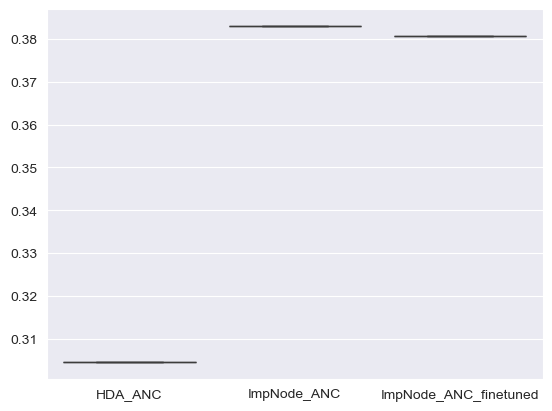

In [8]:
ep_score = {'HDA_ANC':hda_ep_score_history, 'ImpNode_ANC':ep_score_history, 'ImpNode_ANC_finetuned':f_ep_score_history}
sns.boxplot(ep_score)
print(ep_score)

<Axes: >

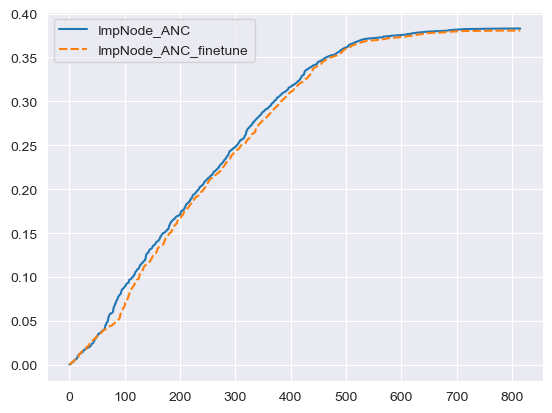

In [9]:
cum_sum_reward_his = np.cumsum(reward_history)
cum_sum_hda_reward_his = np.cumsum(f_reward_history)
sns.lineplot({'ImpNode_ANC':cum_sum_reward_his, 'ImpNode_ANC_finetune':cum_sum_hda_reward_his})

C:\Users\rituja.pardhi\.conda\envs\impnode-gpu\lib\site-packages\torch_geometric\utils\_scatter.py:75: UserWarning: scatter_add_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:86.)
  return src.new_zeros(size).scatter_add_(dim, index, src)


not finetuned 0.2527
finetuned 0.2534


<Axes: >

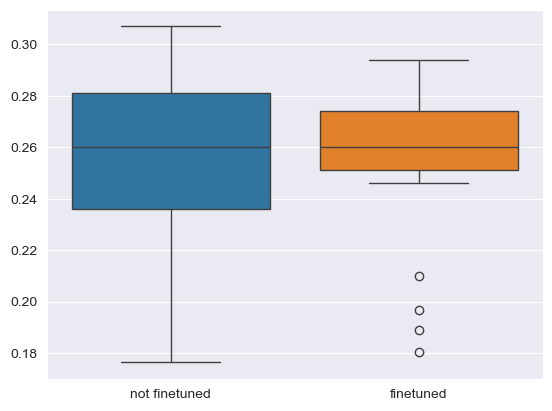

In [10]:
subdir = 'data/cm/Crime_degree_val'

data_path = Path.cwd()/subdir

NUM_TEST_EPS = 20 # number of test episodes to run


env_test2 = ImpnodeEnv(anc='dw_nd', g_type='barabasi_albert', num_nodes=(30, 50), data_path=data_path,mode='test', max_removed_nodes=max_removed_nodes)
actions3, reward_history3, ep_score_history3 = test_loop(env=env_test2,
                                                        agent=dqn_agent_test,
                                                        NUM_TEST_EPS = NUM_TEST_EPS)
# test the agent
actions4, reward_history4, ep_score_history4 = test_loop(env=env_test2,
                                                        agent=dqn_agent_test_finetuned,
                                                        NUM_TEST_EPS = NUM_TEST_EPS)

ep_score2 = {'not finetuned':ep_score_history3, 'finetuned':ep_score_history4}

print(f'not finetuned %.4f' %(np.mean(ep_score_history3)))
print(f'finetuned %.4f' %(np.mean(ep_score_history4)))
sns.boxplot(ep_score2)